In [183]:
import os
import pandas as pd
from sklearn import preprocessing
import numpy as np
import seaborn as sns

threshold_knob = 300

In [184]:
EVENT_FOLDER = './events_csv'
EVENT_FILES = os.listdir(EVENT_FOLDER)

event_list = []
event_names = ['Dallas', 'New Orleans', 'Atlanta', 'Birmingham', ' Pro League 1', 'Relegation', 'Seattle',
               'Anaheim', 'Pro League 2', 'Champs']
event_dict = {}
ww2_snd = []

for x in EVENT_FILES:
    with open('{}/{}'.format(EVENT_FOLDER, x)) as f:
        temp = pd.read_csv(f)
        event_list.append(temp)

event_dict = dict(zip(event_names, event_list))

meta_df = pd.concat(event_list[:])

ww2_snd = meta_df[meta_df['mode'] == 'Search & Destroy']

Slecting the desired variables, removing weapons that were seen to distort the model, and reclassyfying necessary data types. p_df_filt will be the reference dataset for each statistic calcuation.

In [185]:
# stats to be used in model
target_stats = ['match id','player', 'fave weapon', 'kills', 'kills (stayed alive)', 'shots', 
                'time alive (s)', 'snd firstbloods', 'scorestreaks earned', 'snd rounds']

# objects within 'fave weapon' that influence model results
n2low = ['M1 Garand', 'M1941']
distort = ['Kar98k', 'Springfield'] + n2low

# subsetting for stats, removing distorting weapons, and converting necessary columns to numeric.
p_df = ww2_snd[target_stats]
p_df_filt = p_df[~p_df['fave weapon'].isin(distort)].copy()
p_df_filt['time alive (s)'] = pd.to_numeric(p_df_filt['time alive (s)'], errors="coerce")

Each statistic will be calculated in its own dataframe. This may not be the fatest solution but it is the easiest method for visualizing this in my head.

Calculating the average kill per round stat and each players residual value:

In [186]:
akpr = p_df_filt.groupby('player')['kills', 'snd rounds'].sum()
akpr = akpr[akpr['snd rounds'] > threshold_knob]
akpr['akpr'] = akpr['kills']/akpr['snd rounds']
akpr_mu = akpr['akpr'].mean()
akpr['akpr.resid']= akpr['akpr']-akpr_mu

# storing residual into running residual storage list for later calcualtion

resid_list = [akpr['akpr.resid']]

Calculating the average non traded kill per round stat and each players residual value:

In [187]:
antkpr = p_df_filt.groupby('player')['kills (stayed alive)', 'snd rounds'].sum()
antkpr = antkpr[antkpr['snd rounds'] > threshold_knob]
antkpr['antkpr'] = antkpr['kills (stayed alive)']/antkpr['snd rounds']
antkpr_mu = antkpr['antkpr'].mean()
antkpr['antkpr.resid']= antkpr['antkpr']-antkpr_mu

# storing residual into running residual storage list for later calcualtion

resid_list = resid_list + [antkpr['antkpr.resid']]

Calculating the average shots per round stat and each players residual value:

In [188]:
aspr = p_df_filt.groupby('player')['shots', 'snd rounds'].sum()
aspr = aspr[aspr['snd rounds'] > threshold_knob]
aspr['aspr'] = aspr['shots']/aspr['snd rounds']
aspr_mu = aspr['aspr'].mean()
aspr['aspr.resid']= aspr['aspr']-aspr_mu

# storing residual into running residual storage list for later calcualtion
resid_list = resid_list + [aspr['aspr.resid']]

Calculating the average time per life stat and each players residual value:

In [189]:
atapr = p_df_filt.groupby('player')['time alive (s)', 'snd rounds'].sum()
atapr = atapr[atapr['snd rounds'] > threshold_knob]
atapr['atapr'] = atapr['time alive (s)']/atapr['snd rounds']
atapr_mu = atapr['atapr'].mean()
atapr['atapr.resid']= atapr['atapr']-atapr_mu

# storing residual into running residual storage list for later calcualtion
resid_list = resid_list + [atapr['atapr.resid']]

Calculating the average firstblood per round stat and each players residual value:

In [190]:
afbpr = p_df_filt.groupby('player')['snd firstbloods', 'snd rounds'].sum()
afbpr = afbpr[afbpr['snd rounds'] > threshold_knob]
afbpr['afbpr'] = afbpr['snd firstbloods']/afbpr['snd rounds']
afbpr_mu = afbpr['afbpr'].mean()
afbpr['afbpr.resid']= afbpr['afbpr']-afbpr_mu

# storing residual into running residual storage list for later calcualtion
resid_list = resid_list + [afbpr['afbpr.resid']]

Calculating the average score streak per round stat and each players residual value:

In [191]:
astpr = p_df_filt.groupby('player')['scorestreaks earned', 'snd rounds'].sum()
astpr = astpr[astpr['snd rounds'] > threshold_knob]
astpr['astpr'] = astpr['scorestreaks earned']/astpr['snd rounds']
astpr_mu = astpr['astpr'].mean()
astpr['astpr.resid']= astpr['astpr']-astpr_mu

# storing residual into running residual storage list for later calcualtion
resid_list = resid_list + [astpr['astpr.resid']]

Will use the mean to normalize each stat so no one stat is weighted more than the others due to the scale in their inherent variances. The scaled stats will be stored in the dataframe 'scaled'. The scaled stats will be summed to come to each players rating.

In [197]:
resids = pd.concat(resid_list, axis=1)
test = resids.drop(columns = 'aspr.resid')

scaled = test.apply(lambda x: (x - np.mean(x)) / (np.max(x) - np.min(x)))

scaled['rating'] = scaled.sum(axis=1)

,akpr.resid,antkpr.resid,atapr.resid,afbpr.resid,astpr.resid,rating
player,,,,,,
Accuracy,0.316304,0.325384,0.005050,-0.009247,-0.167595,0.469895
Aches,0.086988,0.193491,0.199350,-0.053789,-0.027340,0.398700
Alex,-0.070122,-0.004939,0.277926,-0.129477,0.121118,0.194506
Apathy,-0.041379,-0.085013,-0.060374,0.214805,0.195523,0.223562
Aqua,0.242765,0.411519,0.125341,0.023894,0.118032,0.921550
Arcitys,-0.030152,-0.031444,0.056562,-0.181279,0.272435,0.086121
Assault,0.163624,0.224997,0.311479,0.008586,0.094940,0.803627
Attach,0.198418,0.291666,-0.076732,0.026423,-0.003957,0.435818
Bance,-0.073135,-0.191251,0.022446,0.015233,-0.075683,-0.302390


Now that each player has a scaled rating. it will be important to plot the distribution and analyze the rating list. It looks to range betweeen -1.5 and 1.5 and the mean is 0. This means an average player has a rating of 0 while below average players will be negative and above average players will be positive.

,akpr.resid,antkpr.resid,atapr.resid,afbpr.resid,astpr.resid,rating
player,,,,,,
Denz,0.296462,0.455412,0.097557,0.142590,0.581459,1.573480
Dashy,0.359261,0.508729,-0.101648,0.398576,0.243641,1.408559
Fero,0.513954,0.374585,-0.190846,0.419579,0.052094,1.169366
TJHaly,0.430537,0.384548,-0.309114,0.409046,0.199245,1.114261
Slasher,0.376614,0.454387,0.157949,0.025674,0.098096,1.112718
Xotic,0.205728,0.307783,-0.068232,0.002448,0.587560,1.035287
Aqua,0.242765,0.411519,0.125341,0.023894,0.118032,0.921550
Shockz,0.262528,0.368982,0.119768,0.068308,0.092492,0.912078
Assault,0.163624,0.224997,0.311479,0.008586,0.094940,0.803627


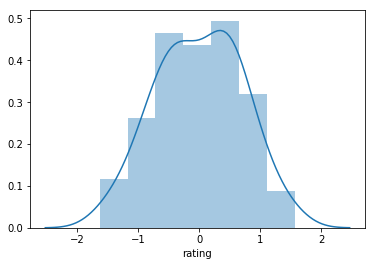

In [216]:
sns.distplot(scaled['rating'])
scaled['rating'].nlargest(10)
scaled.sort_values(by='rating', ascending=False)